In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2


In [2]:
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
import os
import seaborn as sns
from keras.applications.vgg16 import VGG16

In [3]:
print(os.listdir(r"C:\Users\hp\Downloads\Images"))

['test', 'train']


In [4]:
SIZE = 256

In [5]:
train_images = []
train_labels = [] 


In [6]:
for directory_path in glob.glob(r"C:\Users\hp\Downloads\Images\train\*"):
    label = directory_path.split("\\")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpeg")):
        print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        train_labels.append(label)

covid
C:\Users\hp\Downloads\Images\train\covid\f.jpeg
C:\Users\hp\Downloads\Images\train\covid\g.jpeg
C:\Users\hp\Downloads\Images\train\covid\h.jpeg
C:\Users\hp\Downloads\Images\train\covid\i.jpeg
C:\Users\hp\Downloads\Images\train\covid\l.jpeg
C:\Users\hp\Downloads\Images\train\covid\m.jpeg
C:\Users\hp\Downloads\Images\train\covid\n.jpeg
C:\Users\hp\Downloads\Images\train\covid\o.jpeg
C:\Users\hp\Downloads\Images\train\covid\p.jpeg
C:\Users\hp\Downloads\Images\train\covid\q.jpeg
C:\Users\hp\Downloads\Images\train\covid\r.jpeg
C:\Users\hp\Downloads\Images\train\covid\s.jpeg
C:\Users\hp\Downloads\Images\train\covid\t.jpeg
non-covid
C:\Users\hp\Downloads\Images\train\non-covid\10.jpeg
C:\Users\hp\Downloads\Images\train\non-covid\11.jpeg
C:\Users\hp\Downloads\Images\train\non-covid\12.jpeg
C:\Users\hp\Downloads\Images\train\non-covid\13.jpeg
C:\Users\hp\Downloads\Images\train\non-covid\14.jpeg
C:\Users\hp\Downloads\Images\train\non-covid\15.jpeg
C:\Users\hp\Downloads\Images\train\non-cov

In [7]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)


In [8]:
train_images.shape

(73, 256, 256, 3)

In [9]:
train_labels.shape

(73,)

In [10]:
test_images = []
test_labels = [] 
for directory_path in glob.glob(r"C:\Users\hp\Downloads\Images\test\*"):
    Label = directory_path.split("\\")[-1]
    print(Label)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpeg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        test_images.append(img)
        test_labels.append(Label)

covid
non-covid


In [11]:
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [12]:
test_images.shape

(19, 256, 256, 3)

In [13]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

In [14]:
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded


In [15]:
x_train, x_test = x_train / 255.0, x_test / 255.0

In [16]:
from keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)


In [18]:
from keras.applications.resnet50 import ResNet50
Res_model = ResNet50(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))


94773248/94765736 [==============================] - 80s 1us/step


In [19]:
for layer in Res_model.layers:
 layer.trainable = False

In [21]:
Res_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [22]:
feature_extractor=Res_model.predict(x_train)

In [23]:
features = feature_extractor.reshape(feature_extractor.shape[0], -1)

In [24]:
X_for_RF = features

In [25]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='linear')

In [26]:
svclassifier.fit(X_for_RF, y_train)

SVC(kernel='linear')

In [27]:
X_test_feature = Res_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

In [28]:
prediction_RF = svclassifier.predict(X_test_features)

In [29]:
prediction_RF = le.inverse_transform(prediction_RF)

In [30]:
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_RF))


Accuracy =  0.7894736842105263


In [31]:
from sklearn.metrics import confusion_matrix

In [32]:
cm = confusion_matrix(test_labels, prediction_RF)
print(cm)

[[ 2  2]
 [ 2 13]]


<AxesSubplot:>

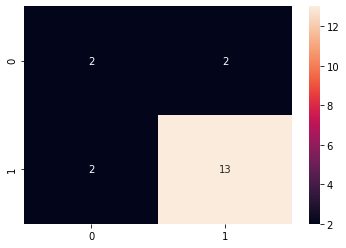

In [33]:
sns.heatmap(cm, annot=True)

The prediction for this image is:  ['non-covid']
The actual label for this image is:  non-covid


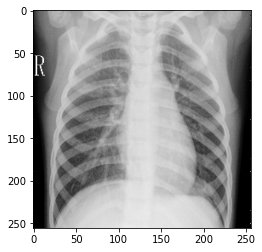

In [34]:
n=np.random.randint(0, x_test.shape[0])
img = x_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) 
input_img_feature=Res_model.predict(input_img)
input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
prediction_RF = svclassifier.predict(input_img_features)[0] 
prediction_RF = le.inverse_transform([prediction_RF]) 
print("The prediction for this image is: ", prediction_RF)
print("The actual label for this image is: ", test_labels[n])


In [35]:
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators = 50, random_state = 42)

In [36]:
RF_model.fit(X_for_RF, y_train)

RandomForestClassifier(n_estimators=50, random_state=42)

In [37]:
prediction_RF = RF_model.predict(X_test_features)

In [38]:
prediction_RF = le.inverse_transform(prediction_RF)

In [39]:
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_RF))

Accuracy =  0.8421052631578947


In [40]:
cm = confusion_matrix(test_labels, prediction_RF)
print(cm)

[[ 2  2]
 [ 1 14]]


<AxesSubplot:>

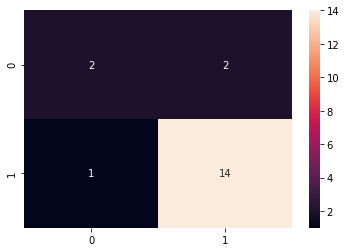

In [41]:
sns.heatmap(cm, annot=True)

In [42]:
from sklearn.neighbors import KNeighborsClassifier
knn_model= KNeighborsClassifier(n_neighbors=5,metric='minkowski')

In [43]:
knn_model.fit(X_for_RF, y_train)

KNeighborsClassifier()

In [44]:
prediction_RF = knn_model.predict(X_test_features)

In [45]:
prediction_RF = le.inverse_transform(prediction_RF)

In [46]:
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_RF))


Accuracy =  0.7894736842105263


In [47]:
from sklearn.naive_bayes import GaussianNB
nb_model = GaussianNB()

In [48]:
nb_model.fit(X_for_RF, y_train)

GaussianNB()

In [49]:
prediction_RF = nb_model.predict(X_test_features)

In [50]:
prediction_RF = le.inverse_transform(prediction_RF)

In [51]:
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_RF))


Accuracy =  0.8421052631578947


In [52]:
from sklearn.ensemble import AdaBoostClassifier
ada_model=AdaBoostClassifier(n_estimators=50)

In [53]:
ada_model.fit(X_for_RF, y_train)

AdaBoostClassifier()

In [54]:
prediction_RF = ada_model.predict(X_test_features)

In [55]:
prediction_RF = le.inverse_transform(prediction_RF)

In [56]:
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_RF))


Accuracy =  0.8947368421052632


In [57]:
from sklearn.gaussian_process import GaussianProcessClassifier
gp_model= GaussianProcessClassifier(kernel=None)

In [58]:
gp_model.fit(X_for_RF, y_train)

GaussianProcessClassifier()

In [59]:
prediction_RF = gp_model.predict(X_test_features)

In [60]:
prediction_RF = le.inverse_transform(prediction_RF)

In [61]:
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_RF))


Accuracy =  0.7368421052631579


In [62]:
from sklearn.svm import SVC
rbf_svm_model=SVC(kernel='rbf')

In [63]:
rbf_svm_model.fit(X_for_RF, y_train)

SVC()

In [64]:
prediction_RF = rbf_svm_model.predict(X_test_features)

In [65]:
prediction_RF = le.inverse_transform(prediction_RF)

In [66]:
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_RF))


Accuracy =  0.7894736842105263


In [67]:
from sklearn.neural_network import MLPClassifier
nn_model=MLPClassifier(hidden_layer_sizes=100, activation='relu',solver='sgd', alpha=0.001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001)

In [68]:
nn_model.fit(X_for_RF, y_train)

MLPClassifier(alpha=0.001, hidden_layer_sizes=100, solver='sgd')

In [69]:
prediction_RF = nn_model.predict(X_test_features)

In [70]:
prediction_RF = le.inverse_transform(prediction_RF)

In [72]:
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_RF))


Accuracy =  0.7894736842105263
